<a href="https://colab.research.google.com/github/SreyaJampana/Cognitive-Distortion-Detection/blob/main/BERT_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Annotated_data.csv to Annotated_data (1).csv


In [ ]:
import pandas as pd

# Reading the uploaded CSV files
df = pd.read_csv('Annotated_data.csv')

In [ ]:
print(len(df))

2530


In [ ]:
print(df.isnull().sum())

Id_Number                             0
Patient Question                      0
Distorted part                      933
Dominant Distortion                   0
Secondary Distortion (Optional)    2114
dtype: int64


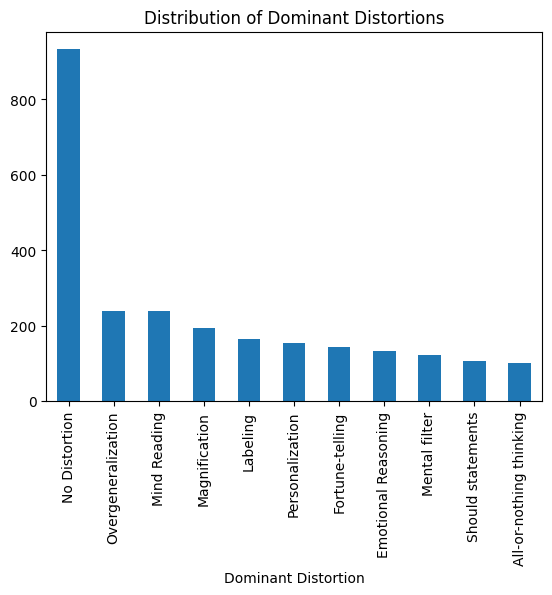

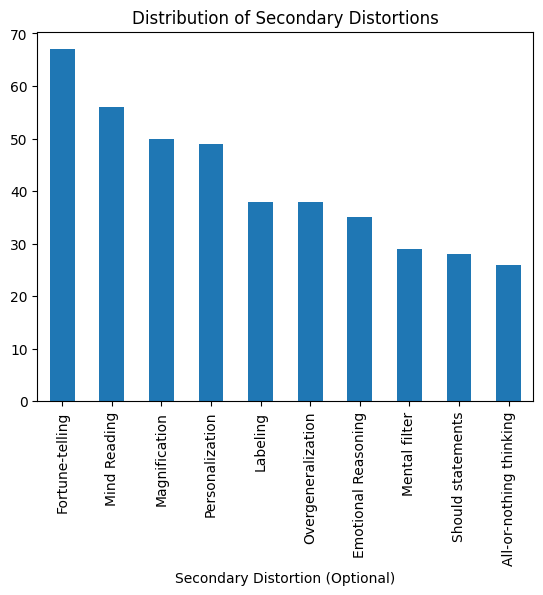

In [ ]:
import matplotlib.pyplot as plt

# Distribution of dominant distortions
df['Dominant Distortion'].value_counts().plot(kind='bar', title='Distribution of Dominant Distortions')
plt.show()

# Distribution of secondary distortions
df['Secondary Distortion (Optional)'].value_counts().plot(kind='bar', title='Distribution of Secondary Distortions')
plt.show()

In [ ]:
import pandas as pd
df['Dominant Distortion'] = df.apply(
    lambda row: row['Secondary Distortion (Optional)'] if row['Dominant Distortion'] == 'No distortion' and pd.notna(row['Secondary Distortion (Optional)']) else row['Dominant Distortion'],
    axis=1
)

# View the updated DataFrame
df.head()

,Id_Number,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,4500,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,4501,Since I was about 16 years old I’ve had these ...,I feel trapped inside my disgusting self and l...,Labeling,Emotional Reasoning
2,4502,So I’ve been dating on and off this guy for a...,NaN,No Distortion,NaN
3,4503,My parents got divorced in 2004. My mother has...,NaN,No Distortion,NaN
4,4504,I don’t really know how to explain the situati...,I refused to go because I didn’t know if it wa...,Fortune-telling,Emotional Reasoning


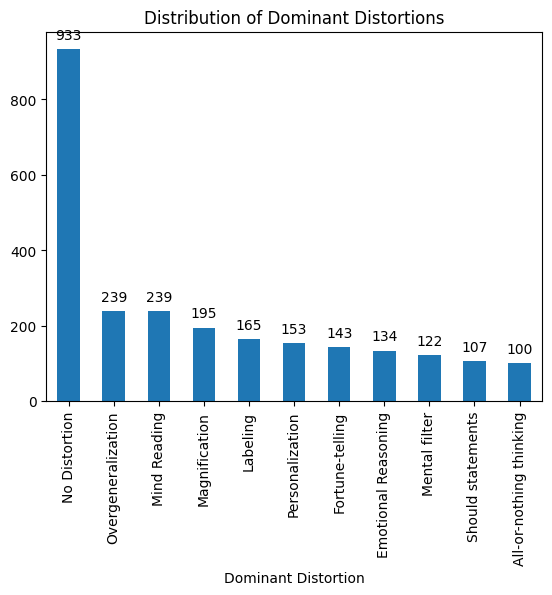

In [ ]:
ax = df['Dominant Distortion'].value_counts().plot(kind='bar', title='Distribution of Dominant Distortions')

# Adding numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Display the plot
plt.show()

In [ ]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)

    # Remove single characters and extra spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['Cleaned_Question'] = df['Patient Question'].apply(clean_text)

In [ ]:
!pip install transformers torch


In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Separate features and labels
X = df['Cleaned_Question']
y = df['Dominant Distortion']

# Initialize the TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(X_tfidf, y)

# Optional: Convert resampled labels to a DataFrame
df_resampled = pd.DataFrame(X_resampled.toarray(), columns=tfidf.get_feature_names_out())
df_resampled['Dominant Distortion'] = y_resampled

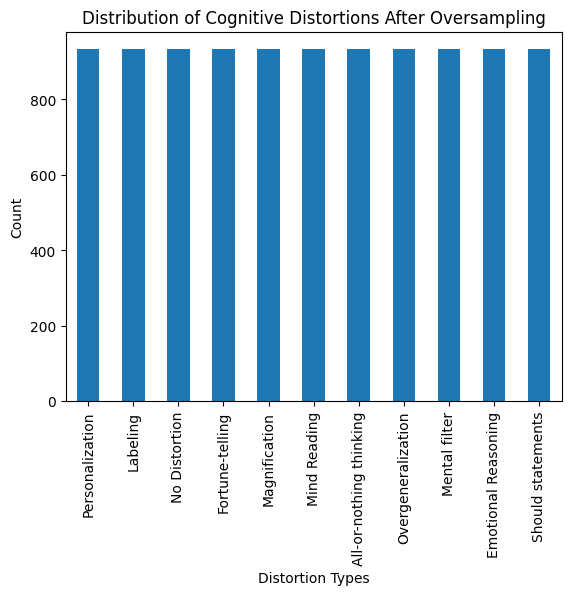

In [ ]:
import matplotlib.pyplot as plt

# Convert y_resampled to a DataFrame for easier plotting
resampled_label_df = pd.DataFrame({'Label': y_resampled})

# Plot the distribution
resampled_label_df['Label'].value_counts().plot(kind='bar', title='Distribution of Cognitive Distortions After Oversampling')
plt.xlabel('Distortion Types')
plt.ylabel('Count')
plt.show()

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

In [ ]:
train_texts_resampled = tfidf.inverse_transform(X_resampled)
train_labels_resampled = y_resampled

# Create a new dataset class for resampled data
class DistortionResampledDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = ' '.join(self.texts[idx])  # Convert list to a single string
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create the resampled dataset
train_dataset_resampled = DistortionResampledDataset(train_texts_resampled, train_labels_resampled, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
predictions = trainer.predict(val_dataset)

# Convert predictions to labels
preds = torch.argmax(torch.tensor(predictions.predictions), dim=1)

# Compute accuracy
from sklearn.metrics import accuracy_score, classification_report

print(f'Accuracy: {accuracy_score(val_labels, preds)}')
print(classification_report(val_labels, preds, target_names=list(label_mapping.keys())))


NameError: name 'trainer' is not defined

In [ ]:
model_save_path = '/Users/sreyajampana/untitled folder'
trainer.save_model(model_save_path)


In [ ]:
print(preds)

In [ ]:
print(val_labels)

In [ ]:
print(df['Cleaned_Question'])

In [ ]:
print(df['Label'].head(10))